This notebook explores the data (TFRecord format) using a subsample of the YouTube-8M `frame-level` and `validate` data. 
To work with the entire dataset, please refer to the Starter code on the [YouTube-8M github repo](https://github.com/google/youtube-8m)

In [1]:
import numpy as np 
import pandas as pd

import os
print(os.listdir("../input"))

['starter-kernel-yt8m-2019-sample-data', 'youtube8m-2019']


In [2]:
print(os.listdir("../input/youtube8m-2019"))

['sample_submission.csv', 'vocabulary.csv', 'frame-sample.zip', 'validate-sample.zip']


In [3]:
import zipfile
import os

zip_path = "../input/youtube8m-2019/frame-sample.zip"  # Path to the ZIP file
extract_path = "/kaggle/working/frame-sample"  # Writable directory for extraction

# Extract the ZIP file
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
    print("Extracted files:", os.listdir(extract_path))
else:
    print("ZIP file not found.")


Extraction complete.
Extracted files: ['frame']


In [4]:
# Loading libraries & datasets
import tensorflow as tf
import numpy as np
from IPython.display import YouTubeVideo

frame_lvl_record = "/kaggle/working/frame-sample/frame/train00.tfrecord"

In [5]:
print(os.listdir("/kaggle/working/frame-sample/frame"))

['train00.tfrecord', 'train01.tfrecord']


## Video-level information (extracted from the frame-level files)

In [6]:
vid_ids = []
labels = []

for example in tf.python_io.tf_record_iterator(frame_lvl_record):
    tf_example = tf.train.Example.FromString(example)
    vid_ids.append(tf_example.features.feature['id']
                   .bytes_list.value[0].decode(encoding='UTF-8'))
    labels.append(tf_example.features.feature['labels'].int64_list.value)

In [7]:
print('Number of videos in this tfrecord: ',len(vid_ids))
print('Picking a youtube video id:',vid_ids[11])

Number of videos in this tfrecord:  1015
Picking a youtube video id: gk00


As described on the YouTube8M download page, for privacy reasons, the video id has been randomly generated and does not directly correspond to the actual YouTube video id. To convert the id into the actua YouTube video id, we follow link: http://data.yt8m.org/2/j/i/UL/UL00.js

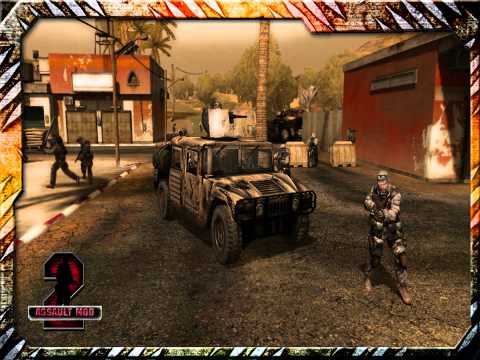

In [8]:
# With that video id, we can play the video
YouTubeVideo('UzXQaOLQVCU')

## Read the frame-level data

In [9]:
# due to execution time, we're only going to read the first video

feat_rgb = []
feat_audio = []

for example in tf.python_io.tf_record_iterator(frame_lvl_record):  
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    sess = tf.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # iterate through frames
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['rgb']
                  .feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        audio_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio']
                  .feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        
        
    sess.close()
    
    feat_audio.append(audio_frame)
    feat_rgb.append(rgb_frame)
    break

In [10]:
print('The first video has %d frames' %len(feat_rgb[0]))

The first video has 234 frames


## Now let's explore the labels
First, we'll find the most commonly used labels...

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import numpy as np

In [12]:
vocab = pd.read_csv('../input/youtube8m-2019/vocabulary.csv')
print("we have {} unique labels in the dataset".format(len(vocab['Index'].unique())))

we have 1000 unique labels in the dataset


In [13]:
n = 30 # although, we'll only show those that appear in the 1,000 for this competition
from collections import Counter

label_mapping =  vocab[['Index', 'Name']].set_index('Index', drop=True).to_dict()['Name']

top_n = Counter([item for sublist in labels for item in sublist]).most_common(n)
top_n_labels = [int(i[0]) for i in top_n]
top_n_label_names = [label_mapping[x] for x in top_n_labels if x in label_mapping] # filter out the labels that aren't in the 1,000 used for this competition
print(top_n_label_names)

['Concert', 'Car', 'Association football', 'Food', 'Dance', 'Motorsport', 'Racing', 'Mobile phone', 'Smartphone', 'Cooking', 'Pet', 'Dish (food)', 'Drum kit']


## Plot the relationships between each of these top labels...


/opt/conda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


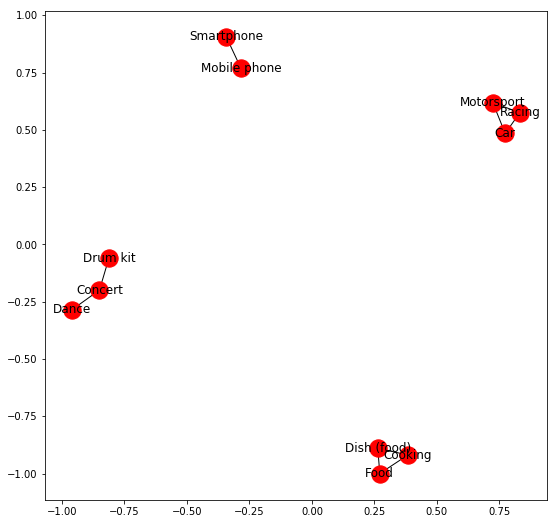

In [14]:
import networkx as nx
from itertools import combinations

G = nx.Graph()

G.clear()
for list_of_nodes in labels:
    filtered_nodes = set(list_of_nodes).intersection(set(top_n_labels) & 
                                                     set(vocab['Index'].unique()))  
    for node1,node2 in list(combinations(filtered_nodes,2)): 
        node1_name = label_mapping[node1]
        node2_name = label_mapping[node2]
        G.add_node(node1_name)
        G.add_node(node2_name)
        G.add_edge(node1_name, node2_name)

plt.figure(figsize=(9,9))
nx.draw_networkx(G, font_size="12")

## Read the validate data

In [15]:
import zipfile
import os

zip_path = "../input/youtube8m-2019/validate-sample.zip"  # Path to the ZIP file
extract_path = "/kaggle/working/validate-sample"  # Writable directory for extraction

# Extract the ZIP file
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
    print("Extracted files:", os.listdir(extract_path))
else:
    print("ZIP file not found.")


Extraction complete.
Extracted files: ['validate']


In [16]:
validate_record = "/kaggle/working/validate-sample/validate/validate00.tfrecord"

In [17]:
val_vid_ids = []
val_vid_labels = []
segment_start_times = []
segment_end_times = []
segment_labels = []
segment_scores = []

for example in tf.python_io.tf_record_iterator(validate_record):
    tf_example = tf.train.Example.FromString(example)
    val_vid_ids.append(tf_example.features.feature['id']
                   .bytes_list.value[0].decode(encoding='UTF-8'))
    val_vid_labels.append(tf_example.features.feature['labels'].int64_list.value)
    segment_start_times.append(tf_example.features.feature['segment_start_times'].int64_list.value)
    segment_end_times.append(tf_example.features.feature['segment_end_times'].int64_list.value)
    segment_labels.append(tf_example.features.feature['segment_labels'].int64_list.value)
    segment_scores.append(tf_example.features.feature['segment_scores'].float_list.value)
    

By inspecting the labels and segment score data, you can see that label 1036 was in the segment 135:140, but _not_ in the other segments!

In [18]:
print(val_vid_ids[0])
print(val_vid_labels[0])
print(segment_start_times[0])
print(segment_end_times[0])
print(segment_labels[0])
print(segment_scores[0])

Iv00
[375, 1036, 1062]
[145, 110, 135, 155, 70]
[150, 115, 140, 160, 75]
[1036, 1036, 1036, 1036, 1036]
[0.0, 0.0, 1.0, 0.0, 0.0]
